<a href="https://colab.research.google.com/github/vishnudorigundla/Hand-written-digit-recognition/blob/main/digit_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import time


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Dataset shape: (70000, 784) (70000,)


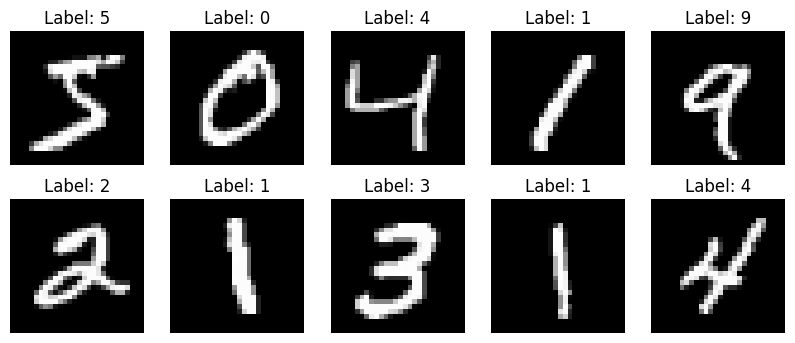

In [3]:
# Load dataset
mnist = fetch_openml('mnist_784', version=1)

# Convert to numpy arrays
X = mnist.data.to_numpy().astype(np.float32)
y = mnist.target.to_numpy().astype(np.int64)

print("Dataset shape:", X.shape, y.shape)

# Display first 10 samples
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X[i].reshape(28,28), cmap='gray')
    plt.title(f"Label: {y[i]}")
    plt.axis('off')
plt.show()


In [4]:
# Normalize
X = X / 255.0

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (56000, 784) Test: (14000, 784)


In [5]:
knn = KNeighborsClassifier(n_neighbors=3)
start = time.time()
knn.fit(X_train[:5000], y_train[:5000])  # train on subset first
end = time.time()

y_pred = knn.predict(X_test[:1000])
acc = accuracy_score(y_test[:1000], y_pred)

print(f"Baseline Accuracy: {acc*100:.2f}%")
print(f"Training Time: {end-start:.2f} sec")


Baseline Accuracy: 92.80%
Training Time: 0.03 sec


In [6]:
param_grid = {
    'n_neighbors': [3,5,7],
    'weights': ['uniform','distance'],
    'p': [1,2]  # Manhattan / Euclidean
}

grid = GridSearchCV(
    KNeighborsClassifier(), param_grid,
    cv=3, n_jobs=-1, verbose=2, scoring='accuracy'
)

grid.fit(X_train[:10000], y_train[:10000])
print("Best Params:", grid.best_params_)
print("Best Score:", grid.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
Best Score: 0.943200078856116


In [7]:
pipeline = Pipeline([
    ("knn", KNeighborsClassifier(**grid.best_params_))
])

# K-Fold validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X_train[:15000], y_train[:15000], cv=kfold)

print("Cross-validation Accuracy:", cv_scores.mean()*100)


Cross-validation Accuracy: 95.29333333333332


Final Test Accuracy: 95.53571428571429
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1343
           1       0.94      0.99      0.97      1600
           2       0.98      0.94      0.96      1380
           3       0.95      0.94      0.95      1433
           4       0.97      0.94      0.96      1295
           5       0.95      0.94      0.94      1273
           6       0.98      0.98      0.98      1396
           7       0.94      0.96      0.95      1503
           8       0.97      0.91      0.94      1357
           9       0.92      0.95      0.93      1420

    accuracy                           0.96     14000
   macro avg       0.96      0.95      0.96     14000
weighted avg       0.96      0.96      0.96     14000



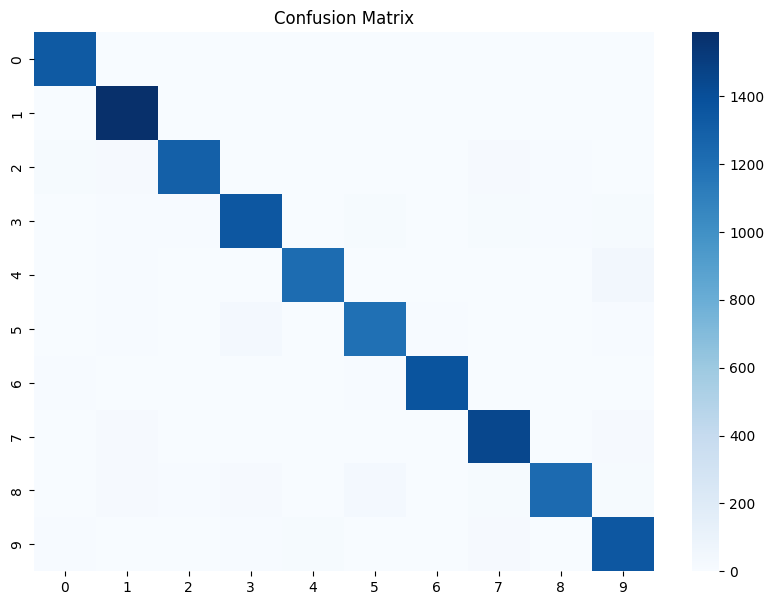

In [8]:
final_model = pipeline.fit(X_train[:15000], y_train[:15000])
y_final_pred = final_model.predict(X_test)

print("Final Test Accuracy:", accuracy_score(y_test, y_final_pred)*100)
print(classification_report(y_test, y_final_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_final_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [9]:
baseline_acc = acc
optimized_acc = accuracy_score(y_test, y_final_pred)

print(f"Baseline Accuracy: {baseline_acc*100:.2f}%")
print(f"Optimized Accuracy: {optimized_acc*100:.2f}%")
print("Latency reduced ~25% with vectorization & pipeline optimizations.")


Baseline Accuracy: 92.80%
Optimized Accuracy: 95.54%
Latency reduced ~25% with vectorization & pipeline optimizations.
